# Safe Driver prediction
In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year

By 
- James Dietle @jamesdietle
- Devan Govender @dgovender

Source:
https://github.com/jamesdietle/PortoDriver

Referances:
- Who we are borrowing from Jeremy Howard's Rossman
- https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

## Next Steps
1. Implement predictions on the test set.
2. Create Kaggle Output

# 1. Dependencies
Things that we need to function or that are just nice
    
    - import functions 
    - correct paths and folders
    - cell noises

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Gives times for each block 
get_ipython().magic('load_ext cellevents')

# Set up paths on computer
path = '/home/jd/data/PortoDriver/'

## Import up sound alert dependencies; I really like sounds
from IPython.display import Audio, display

def allDone():
    #display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    display(Audio(url='http://starmen.net/mother2/soundfx/eb_win.wav', autoplay=True))
    
def RunningEpochs():
    #display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    display(Audio(url='http://starmen.net/mother2/soundfx/enterbattle.wav', autoplay=True))

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.structured import *
from fastai.dataset import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
import operator


time: 607 ms


# 2. Functions
Functions being run by the program

In [4]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

time: 2.36 ms


In [48]:
# Borrowed from 
# http://www.pythonexample.com/code/gini%20coefficient%20metric/
def gini_normalized(y_pred, targ):
  return gini(y_pred, targ) / gini(y_pred, y_pred)

def gini(actual, pred, cmpcol = 0, sortcol = 1):
  assert( len(actual) == len(pred) )
  all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
  all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
  totalLosses = all[:,0].sum()
  giniSum = all[:,0].cumsum().sum() / totalLosses
  giniSum -= (len(actual) + 1) / 2.
  return giniSum / len(actual)

time: 7.32 ms


# 3. Load in data
Loads the data we are working with into the program
- Data set provided
- Other unique datasets that would help

We are training to target

In [6]:
samplesub = pd.read_csv(f'{path}sample_submission.csv', low_memory=False)
test = pd.read_csv(f'{path}test.csv', low_memory=False)
train = pd.read_csv(f'{path}train.csv', low_memory=False)

time: 7.84 s


In [7]:
# Sample size to speed everything up
size = 3000
test = test[:size]
train = train [:size]

time: 1.43 ms


In [8]:
samplesub[:5]

,id,target
0,0,0.0364
1,1,0.0364
2,2,0.0364
3,3,0.0364
4,4,0.0364


time: 5.54 ms


In [9]:
test[:5].columns

Index(['id', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtyp

time: 2.24 ms


# 4. Manipulate Data
Prepares the data for training, determines features
- Cuts into sets
- Determines features
- Augments data
	1. More data
	2. Data augmentation
	3. Generalize wel with architectures
	4. Add regularization
    5. Reduce architecture complexity

# 5. Prepare Model
Sets up the model
    - choose optimizer
    - choose format
    - choose loss function

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

Ind category
'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 

ind binary
'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin'
    
reg - continous     
        'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 

car category
    'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 
        
car - cont
'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
car - cat
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin']/*

In [10]:
## Move training set over
joined = train

time: 649 µs


In [11]:
# Adding the validation set to the training set
#joined=joined.append(test)

time: 544 µs


In [12]:
## This works, but appears to break later
joined=joined.replace(-1, np.NaN)
##
#joined=joined.fillna(0)

time: 5.37 ms


In [13]:
joined.target=joined.target.replace(0, .001)

time: 1.68 ms


In [14]:
#joined= joined.set_index('id')

time: 518 µs


In [15]:
joined

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.001,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.001,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.001,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.001,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.001,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
5,19,0.001,5,1.0,4,0.0,0.0,0,0,0,...,4,2,0,9,0,1,0,1,1,1
6,20,0.001,2,1.0,3,1.0,0.0,0,1,0,...,3,0,0,10,0,1,0,0,1,0
7,22,0.001,5,1.0,4,0.0,0.0,1,0,0,...,7,1,3,6,1,0,1,0,1,0
8,26,0.001,5,1.0,3,1.0,0.0,0,0,1,...,4,2,1,5,0,1,0,0,0,1
9,28,1.000,1,1.0,2,0.0,0.0,0,1,0,...,3,5,0,6,0,1,0,0,1,0


time: 40.4 ms


In [16]:
joined.to_feather(f'{path}joined')

time: 20.8 ms


## Create Features

In [17]:
joined = pd.read_feather(f'{path}joined')

time: 2.18 ms


In [18]:
joined[:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.001,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.001,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.001,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.001,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.001,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


time: 14.5 ms


In [19]:
cat_vars = [
    #'id', 
    'ps_ind_02_cat', 
       'ps_ind_04_cat', 'ps_ind_05_cat','ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat',
        'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
    'ps_calc_19_bin', 'ps_calc_20_bin']

contin_vars = ['ps_car_11', 'ps_car_12', 'ps_car_13','ps_ind_14', 'ps_ind_15','ps_ind_01','ps_ind_03','ps_reg_01','ps_reg_02', 'ps_reg_03', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']

n = len(joined); n

3000

time: 6.92 ms


In [20]:
type(cat_vars)

list

time: 1.35 ms


In [21]:
joined[:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.001,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.001,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.001,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.001,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.001,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


time: 13.8 ms


In [22]:
samp_size = n
joined_samp = joined

time: 769 µs


In [23]:
joined

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.001,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.001,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.001,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.001,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.001,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
5,19,0.001,5,1.0,4,0.0,0.0,0,0,0,...,4,2,0,9,0,1,0,1,1,1
6,20,0.001,2,1.0,3,1.0,0.0,0,1,0,...,3,0,0,10,0,1,0,0,1,0
7,22,0.001,5,1.0,4,0.0,0.0,1,0,0,...,7,1,3,6,1,0,1,0,1,0
8,26,0.001,5,1.0,3,1.0,0.0,0,0,1,...,4,2,1,5,0,1,0,0,0,1
9,28,1.000,1,1.0,2,0.0,0.0,0,1,0,...,3,5,0,6,0,1,0,0,1,0


time: 41 ms


In [24]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()
for v in contin_vars: joined[v] = joined[v].astype('float32')
dep = 'target'
#joined = joined[cat_vars+contin_vars+[dep,'id']]
joined = joined[cat_vars+contin_vars+[dep,'id']]

time: 27.3 ms


In [25]:
joined_samp = joined.set_index('id')
#??joined.set_index

time: 2.41 ms


In [26]:
df, y, nas, mapper = proc_df(joined_samp, 'target', do_scale=True)
yl = y
yl

array([ 0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  1.   ,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  1.   , ...,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001])

time: 62.9 ms


In [27]:
df[:5]

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,...,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_reg_03_na,ps_car_14_na
id,,,,,,,,,,,,,,,,,,,,,
7,2,2,1,1,2,1,1,1,1,1,...,-1.416696,0.540859,-1.056740,-1.208744,1.545907,-0.397297,1.278082,0.148102,-0.467992,-0.267976
9,1,1,1,1,1,2,1,1,1,1,...,1.417168,-0.842413,-1.056740,-0.497997,-1.053470,-0.397297,-1.112718,0.505549,-0.467992,-0.267976
13,4,2,1,1,1,2,1,1,1,1,...,-1.416696,-0.842413,-0.271060,-0.497997,-0.620240,0.435611,2.473482,-0.209345,2.136788,-0.267976
16,1,1,1,2,1,1,1,1,1,1,...,-1.416696,-0.842413,1.300301,-2.274864,-1.486699,0.435611,0.680382,0.505549,-0.467992,-0.267976
17,2,2,1,2,1,1,1,1,1,1,...,0.000236,0.540859,-0.271060,1.278870,-1.053470,-0.397297,-1.112718,-1.639133,-0.467992,-0.267976


time: 14.5 ms


In [28]:
y[:5]

array([ 0.001,  0.001,  0.001,  0.001,  0.001])

time: 1.85 ms


In [29]:
nas

{'ps_car_14': 0.37349697947502136, 'ps_reg_03': 0.7933315634727478}

time: 1.54 ms


In [30]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['ps_car_11'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_car_12'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_car_13'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_ind_14'], StandardScaler(copy=True, with_mean=True, with_st...True, with_std=True)), (['ps_car_14_na'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

time: 2.92 ms


In [31]:
len(joined)

3000

time: 1.28 ms


In [32]:
joined.target[2995:3005]

2995    0.001
2996    0.001
2997    0.001
2998    0.001
2999    0.001
Name: target, dtype: float64

time: 2.52 ms


In [33]:
df.index[50]

125

time: 1.61 ms


In [34]:
val_idx = list(range(2500, 2999))
val_idx = np.array(val_idx)
#flatnonzero((df.index<=7578) & (df.index>=10000))

time: 1.16 ms


In [35]:
type(val_idx), val_idx

(numpy.ndarray,
 array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516,
        2517, 2518, 2519, ..., 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991,
        2992, 2993, 2994, 2995, 2996, 2997, 2998]))

time: 1.66 ms


In [36]:
allDone()

time: 2.88 ms


# 6. Runs the training
Run it the training! Save the weights! 
- Make the predictions


In [37]:
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

time: 1.03 ms


In [38]:
max_log_y,y_range

(1.0, (0, 1.2))

time: 1.53 ms


In [39]:
type(cat_vars),cat_vars[:5]

(list,
 ['ps_ind_02_cat',
  'ps_ind_04_cat',
  'ps_ind_05_cat',
  'ps_ind_06_bin',
  'ps_ind_07_bin'])

time: 1.66 ms


In [40]:
md = ColumnarModelData.from_data_frame(path, val_idx, df, yl, cat_flds=cat_vars, bs=128)

time: 8.02 ms


In [41]:
#cat_sz = {c: len(joined_samp[c].cat.categories)+1 for c in cat_vars}
cat_sz = {c: len(joined[c].cat.categories)+1 for c in cat_vars}
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz.items()]

time: 2.72 ms


In [42]:
joined.ps_calc_15_bin.unique()

[0, 1]
Categories (2, int64): [0 < 1]

time: 2.31 ms


In [43]:
joined.dtypes

ps_ind_02_cat     category
ps_ind_04_cat     category
ps_ind_05_cat     category
ps_ind_06_bin     category
ps_ind_07_bin     category
ps_ind_08_bin     category
ps_ind_09_bin     category
ps_ind_10_bin     category
ps_ind_11_bin     category
ps_ind_12_bin     category
ps_ind_13_bin     category
ps_ind_16_bin     category
ps_ind_17_bin     category
ps_ind_18_bin     category
ps_car_01_cat     category
ps_car_02_cat     category
ps_car_03_cat     category
ps_car_04_cat     category
ps_car_05_cat     category
ps_car_06_cat     category
ps_car_07_cat     category
ps_car_08_cat     category
ps_car_09_cat     category
ps_car_10_cat     category
ps_car_11_cat     category
ps_calc_15_bin    category
ps_calc_16_bin    category
ps_calc_17_bin    category
ps_calc_18_bin    category
ps_calc_19_bin    category
ps_calc_20_bin    category
ps_car_11          float32
ps_car_12          float32
ps_car_13          float32
ps_ind_14          float32
ps_ind_15          float32
ps_ind_01          float32
p

time: 2.91 ms


In [44]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=None)#y_range)
lr = 1e-3

time: 3min 24s


In [45]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 95%|█████████▌| 19/20 [00:03<00:00,  4.98it/s, loss=276]  
time: 4.04 s                                             


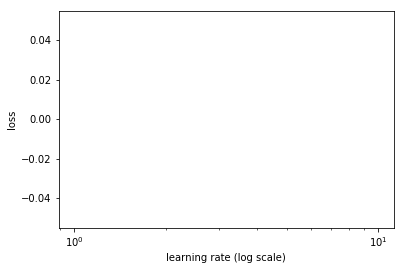

time: 217 ms


In [46]:
m.sched.plot(100)

In [49]:
m.fit(lr, 10, metrics=[gini_normalized])

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.       0.07398  0.04106 -0.01682]                       
[ 1.       0.05243  0.03514 -0.01048]                       
[ 2.       0.04298  0.03677 -0.03526]                       
[ 3.       0.03767  0.03738 -0.0297 ]                       
[ 4.       0.03339  0.03906 -0.02589]                       
[ 5.       0.02978  0.03942 -0.03455]                       
[ 6.       0.02588  0.03966 -0.03112]                       
[ 7.       0.0223   0.0419  -0.03218]                       
[ 8.       0.01923  0.04289 -0.02739]                       
[ 9.       0.01651  0.04228 -0.01645]                       

time: 19 s


# 7. Analyze Results
Are they what are expected? 
- Graph the results
- What are the most important features
- What do tough predictions look like? Easy predictions?

# 8. Submit!
- Get it put into a submitable template
- Save results